In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer

import matplotlib.pyplot as plt
import seaborn as sns

# Insight on Numeric Features
 Below I will display the results which have lead to actionable insight.
 
 ## In summary:
 - The most important predictor in how long a video will remain on trending, is how quickly it reached the trending page.
 - Upon first appearance on trending, the most important feature in predicting the number of days a video will remain on trending is the number of views it has in that instance.
 - An important feature to determine the length of time a video will remain on trending is the like rate (likes/views). Like rate represents viewer engagement. The like rate per region peaks roughly two hours after the most popular upload time.

In [2]:


ENG_df = pd.read_csv('../../data/data.csv')
ENG_df = ENG_df.drop(['days_till_trending'], axis=1)

ENG_df['like_rate'] = ENG_df['likes']/ENG_df['views']*100
ENG_df['dislike_rate'] = ENG_df['dislikes']/ENG_df['views']*100
ENG_df['comment_rate'] = ENG_df['comment_count']/ENG_df['views']*100


US_init = ENG_df[ENG_df['country']== 'us']
GB_init = ENG_df[ENG_df['country']== 'gb']
CA_init = ENG_df[ENG_df['country']== 'ca']

#Addingn columns into each region's dataframe which represents the number of days a video remains trending. 
occurances_US = US_init.groupby(['video_id']).size()
days_trending_US = occurances_US.to_frame(name = 'days_trending').reset_index()

US = pd.merge(left=US_init, right=days_trending_US, left_on='video_id', right_on='video_id', how='outer')

occurances_GB = GB_init.groupby(['video_id']).size()
days_trending_GB = occurances_GB.to_frame(name = 'days_trending').reset_index()

GB = pd.merge(left=GB_init, right=days_trending_GB, left_on='video_id', right_on='video_id', how='outer')

occurances_CA = CA_init.groupby(['video_id']).size()
days_trending_CA = occurances_CA.to_frame(name = 'days_trending').reset_index()

CA = pd.merge(left=CA_init, right=days_trending_CA, left_on='video_id', right_on='video_id', how='outer')

US_last = US.drop_duplicates(['video_id'], keep='last')
US_first = US.drop_duplicates(['video_id'], keep='first')

GB_last = GB.drop_duplicates(['video_id'], keep='last')
GB_first = GB.drop_duplicates(['video_id'], keep='first')

CA_last = CA.drop_duplicates(['video_id'], keep='last')
CA_first = CA.drop_duplicates(['video_id'], keep='first')



## Best features to predict days on trending
When selecting the best 5 features, per region, upon the first occurrence of a video on trending, the following best features were selected. The target variable is the number of days a video will remain trending. 

The goal is to understand, upon a video's first occurrence on trending, which are the top 5 features the YouTube algorithm considers in determining how long the video will remain on trending.

In [3]:
X_US_first = US_first.iloc[:,[8,22,23,24,19,20,21]]
y_US_first = US_first.iloc[:,-2]

X_GB_first = GB_first.iloc[:,[8,22,23,24,19,20,21]]
y_GB_first = GB_first.iloc[:,-2]

X_CA_first = CA_first.iloc[:,[8,22,23,24,19,20,21]]
y_CA_first = CA_first.iloc[:,-2]

X_US_last = US_last.iloc[:,[22,23,24,19,20,21]]
Y_US_last = US_last.iloc[:,-1]

X_GB_last = GB_last.iloc[:,[22,23,24,19,20,21]]
Y_GB_last = GB_last.iloc[:,-1]

X_CA_last = CA_last.iloc[:,[22,23,24,19,20,21]]
Y_CA_last = CA_last.iloc[:,-1]


In [4]:
US_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
US_first_new = US_first_selector.fit_transform(X_US_first, y_US_first)
#print(US_first_new[:5])
#print(X_US_first)

scores_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'Score': US_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})

print("US_first scores")
print(scores_US_first.sort_values(by=['Score'], ascending=False))

US_first scores
       Variable     Score
3  comment_rate  7.414734
1     like_rate  0.350740
2  dislike_rate  0.204244
0         views  0.030303
4          hour  0.025917
5        minute  0.016927
6        second  0.000000


In [5]:
GB_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
GB_first_new = GB_first_selector.fit_transform(X_GB_first, y_GB_first)
#print(US_first_new[:5])
#print(X_US_first)

scores_GB_first = pd.DataFrame({'Variable' : X_GB_first.columns, 'Score': GB_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})
print("GB_first scores")
print(scores_GB_first.sort_values(by=['Score'], ascending=False))

GB_first scores
       Variable     Score
3  comment_rate  6.789179
1     like_rate  0.355185
2  dislike_rate  0.212639
4          hour  0.061711
5        minute  0.030114
0         views  0.000000
6        second  0.000000


In [6]:
CA_first_selector = SelectKBest(score_func=mutual_info_regression, k=5)
CA_first_new = CA_first_selector.fit_transform(X_CA_first, y_CA_first)


scores_CA_first = pd.DataFrame({'Variable' : X_CA_first.columns, 'Score': CA_first_selector.scores_})
#pvalue_US_first = pd.DataFrame({'Variable' : X_US_first.columns, 'p values' : US_first_selector.pvalues_})
print("CA_first scores")
print(scores_CA_first.sort_values(by=['Score'], ascending=False))

CA_first scores
       Variable     Score
3  comment_rate  8.766293
1     like_rate  0.318499
2  dislike_rate  0.101478
4          hour  0.058460
0         views  0.037303
6        second  0.013990
5        minute  0.007860


As can be seen above, views is the best feature (although the score is low). This means that, upon it's first appearance on the trending page, a video with a higher number of views will remain trending for longer. For each feature selection, the most important features are listed in order.


In [7]:
#features considered are, hour, minute, second, like rate, dislike rate, comment rate, days to trending
US_first['publish_date'] = pd.to_datetime(US_first['publish_date'])
US_first['trending_date'] = pd.to_datetime(US_first['trending_date'], format="%y.%d.%m")
US_first['days_to_trending'] = (US_first['trending_date'] - US_first['publish_date'])
US_first['days_to_trending'] = US_first['days_to_trending'].dt.days.astype(int)

#GB dataframe
GB_first['publish_date'] = pd.to_datetime(GB_first['publish_date'])
GB_first['trending_date'] = pd.to_datetime(GB_first['trending_date'], format="%y.%d.%m")
GB_first['days_to_trending'] = (GB_first['trending_date'] - GB_first['publish_date'])
GB_first['days_to_trending'] = GB_first['days_to_trending'].dt.days.astype(int)

#CA dataframe
CA_first['publish_date'] = pd.to_datetime(CA_first['publish_date'])
CA_first['trending_date'] = pd.to_datetime(CA_first['trending_date'], format="%y.%d.%m")
CA_first['days_to_trending'] = (CA_first['trending_date'] - CA_first['publish_date'])
CA_first['days_to_trending'] = CA_first['days_to_trending'].dt.days.astype(int)

X_US_diff = US_first.iloc[:,[19,20,21,22,23,24,26]]
#target is still days_trending
y_US_diff = US_first.iloc[:,25]

X_GB_diff = GB_first.iloc[:,[19,20,21,22,23,24,26]]
y_GB_diff = GB_first.iloc[:,25]

X_CA_diff = CA_first.iloc[:,[19,20,21,22,23,24,26]]
y_CA_diff = CA_first.iloc[:,25]

C:\Users\marwa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marwa\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\marwa\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [8]:
US_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
US_diff_new = US_diff_selector.fit_transform(X_US_diff, y_US_diff)

US_diff_scores = pd.DataFrame({'Variable' : X_US_diff.columns, 'Score': US_diff_selector.scores_})

print(US_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
6  days_to_trending  0.098388
3         like_rate  0.046476
5      comment_rate  0.034343
0              hour  0.021937
4      dislike_rate  0.017695
1            minute  0.013148
2            second  0.006251


In [9]:
CA_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
CA_diff_new = CA_diff_selector.fit_transform(X_CA_diff, y_CA_diff)

CA_diff_scores = pd.DataFrame({'Variable' : X_CA_diff.columns, 'Score': CA_diff_selector.scores_})

print(CA_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
3         like_rate  0.026325
5      comment_rate  0.009566
6  days_to_trending  0.007908
4      dislike_rate  0.006540
0              hour  0.004518
2            second  0.001972
1            minute  0.000000


In [10]:
GB_diff_selector = SelectKBest(score_func=mutual_info_regression, k=5)
GB_diff_new = GB_diff_selector.fit_transform(X_GB_diff, y_GB_diff)

GB_diff_scores = pd.DataFrame({'Variable' : X_GB_diff.columns, 'Score': GB_diff_selector.scores_})

print(GB_diff_scores.sort_values(by=['Score'], ascending=False))

           Variable     Score
6  days_to_trending  0.148413
3         like_rate  0.038977
1            minute  0.026292
2            second  0.021650
0              hour  0.012725
4      dislike_rate  0.012040
5      comment_rate  0.009305


When the feature days_to_trending was included in the feature selection model. days_to_trending showed to have a significantly stronger relationship with the target variable days_trending. 

Therefore, it is clear that, a video that reaches the trending page soon will tend to remain on trending for longer.


## Selecting best predictors for days to trending

Next I will select the best 5 features to predict the number of days a video will take to reach the trending page. My considered variables are like rate, comment rate, dislike rate, hour uploaded, minute uploaded, second uploaded.

In [11]:

#select best predictors for days_to_trending
X_US_first2 = US_first.iloc[:,[22,23,24,19,20,21]]
y_US_first2 = US_first.iloc[:,-1]

X_GB_first2 = GB_first.iloc[:,[22,23,24,19,20,21]]
y_GB_first2 = GB_first.iloc[:,-1]

X_CA_first2 = CA_first.iloc[:,[22,23,24,19,20,21]]
y_CA_first2 = CA_first.iloc[:,-1]


In [12]:
GB_diff_selector2 = SelectKBest(score_func=mutual_info_regression, k=5)
GB_diff_new2 = GB_diff_selector2.fit_transform(X_GB_first2, y_GB_first2)

GB_diff_scores2 = pd.DataFrame({'Variable' : X_GB_first2.columns, 'Score': GB_diff_selector2.scores_})

print(GB_diff_scores2.sort_values(by=['Score'], ascending=False))

       Variable     Score
2  comment_rate  0.078381
0     like_rate  0.076640
3          hour  0.059724
1  dislike_rate  0.037577
4        minute  0.002253
5        second  0.000287


In [13]:
US_diff_selector2 = SelectKBest(score_func=mutual_info_regression, k=5)
US_diff_new2 = US_diff_selector2.fit_transform(X_US_first2, y_US_first2)

US_diff_scores2 = pd.DataFrame({'Variable' : X_US_first2.columns, 'Score': US_diff_selector2.scores_})

print(US_diff_scores2.sort_values(by=['Score'], ascending=False))

       Variable     Score
3          hour  0.080451
0     like_rate  0.064894
2  comment_rate  0.044154
1  dislike_rate  0.034933
4        minute  0.000000
5        second  0.000000


In [14]:
CA_diff_selector2 = SelectKBest(score_func=mutual_info_regression, k=5)
CA_diff_new2 = CA_diff_selector2.fit_transform(X_CA_first2, y_CA_first2)

CA_diff_scores2 = pd.DataFrame({'Variable' : X_CA_first2.columns, 'Score': CA_diff_selector2.scores_})

print(CA_diff_scores2.sort_values(by=['Score'], ascending=False))

       Variable     Score
3          hour  0.166895
2  comment_rate  0.028798
0     like_rate  0.014495
1  dislike_rate  0.008540
4        minute  0.007332
5        second  0.002942


The best 5 features to predict the days taken to reach trending are :
1. Hour uploaded
2. Like rate
3. Comment rate
4. Dislike Rate
5. Minute uploaded


## Top Upload Hour, Top Hour by Like Rate

It is clear that like rate is one of the top 5 best features that was selected in every instance above. Therefore, I plot the like rate per hour uploaded. The results are as follows:

C:\Users\marwa\anaconda3\lib\site-packages\seaborn\categorical.py:2619: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


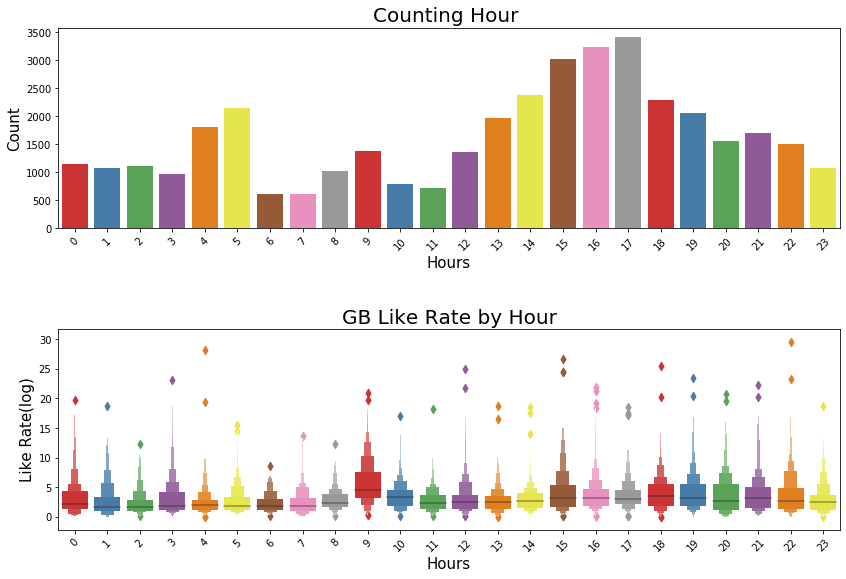

In [15]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=GB, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=GB, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("GB Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

C:\Users\marwa\anaconda3\lib\site-packages\seaborn\categorical.py:2619: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


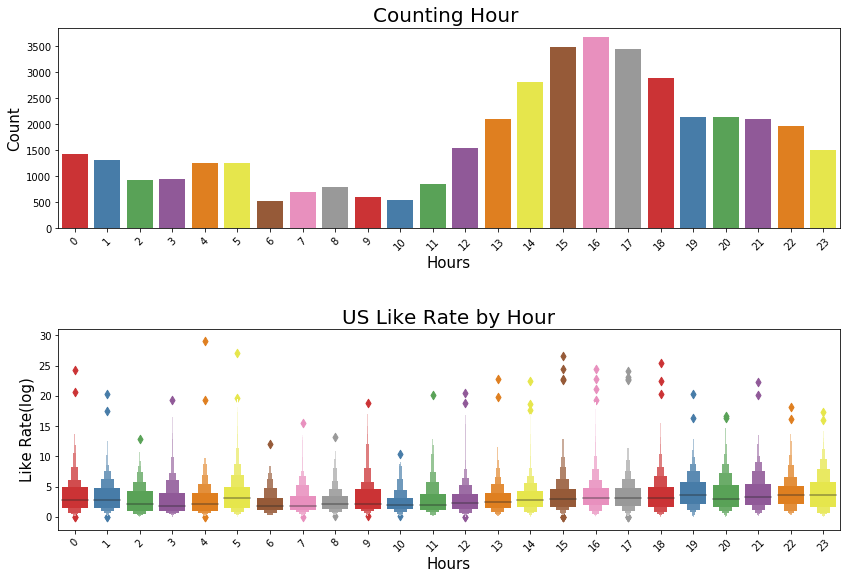

In [16]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=US, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=US, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("US Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

C:\Users\marwa\anaconda3\lib\site-packages\seaborn\categorical.py:2619: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


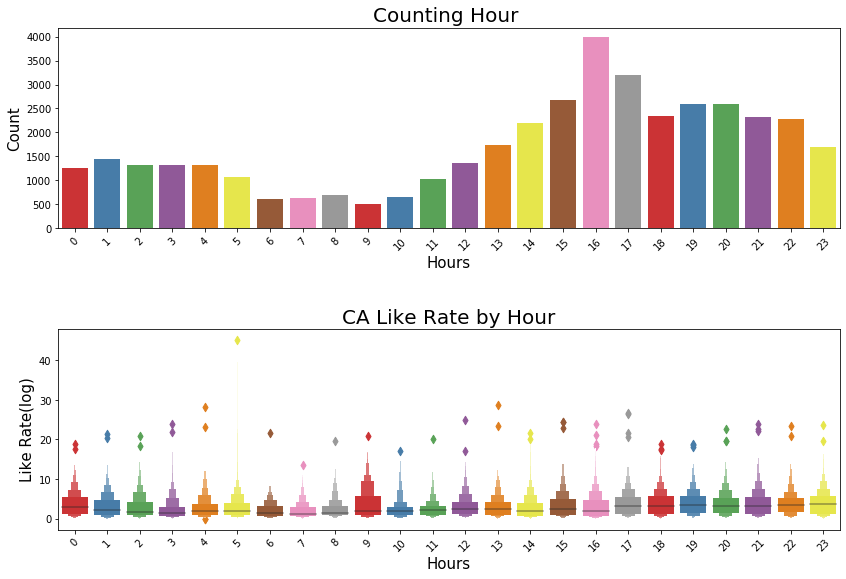

In [17]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('hour', data=CA, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting Hour ", fontsize=20)
g.set_xlabel("Hours", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(212)
g1 = sns.lvplot(x='hour', y='like_rate', data=CA, palette="Set1")
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("CA Like Rate by Hour", fontsize=20)
g1.set_xlabel("Hours", fontsize=15)
g1.set_ylabel("Like Rate(log)", fontsize=15)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

It is clear that, for each region, the hour with the highest like rate is closely succeeding the top hour videos are uploaded in. This is likely due to the fact that as videos are uploaded, a content creators core audience will view and engage with the video, leaving a slightly lagged peak for like_rate per hour. A higher like rate influences the speed at which a video reaches the trending page, as well as the length of time it remains on trending.